In [67]:
import numpy as np
import cv2                 # working with, mainly resizing, images
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion
import matplotlib

In [68]:
"""import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D"""

'import keras\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout, Activation, Flatten\nfrom keras.layers import Conv2D, MaxPooling2D'

In [69]:
TRAIN_DIR = 'F:/hst_sync_2017/python/machine_vision/dogvscat/train'
TEST_DIR = 'F:/hst_sync_2017/python/machine_vision/dogvscat/test1'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '8conv-9layers-version') 

In [70]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [71]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [72]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [73]:
#train_data = create_train_data()
# If you have already created the dataset:
train_data = np.load('train_data.npy')

In [74]:
#test_data = process_test_data()
test_data = np.load('test_data.npy')

In [75]:
#build tf learn cnn model

In [76]:
batch_size = 128
num_classes = 10
epochs = 12

In [77]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [78]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [79]:
train = train_data[:-300]
test = train_data[-300:]

In [80]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [114]:
model.fit({'input': X}, {'targets': Y}, n_epoch=2, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 5789  | total loss: 0.21275 | time: 73.444s
| Adam | epoch: 015 | loss: 0.21275 - acc: 0.9156 -- iter: 24640/24700
Training Step: 5790  | total loss: 0.20789 | time: 74.653s
| Adam | epoch: 015 | loss: 0.20789 - acc: 0.9194 | val_loss: 0.74551 - val_acc: 0.7933 -- iter: 24700/24700
--


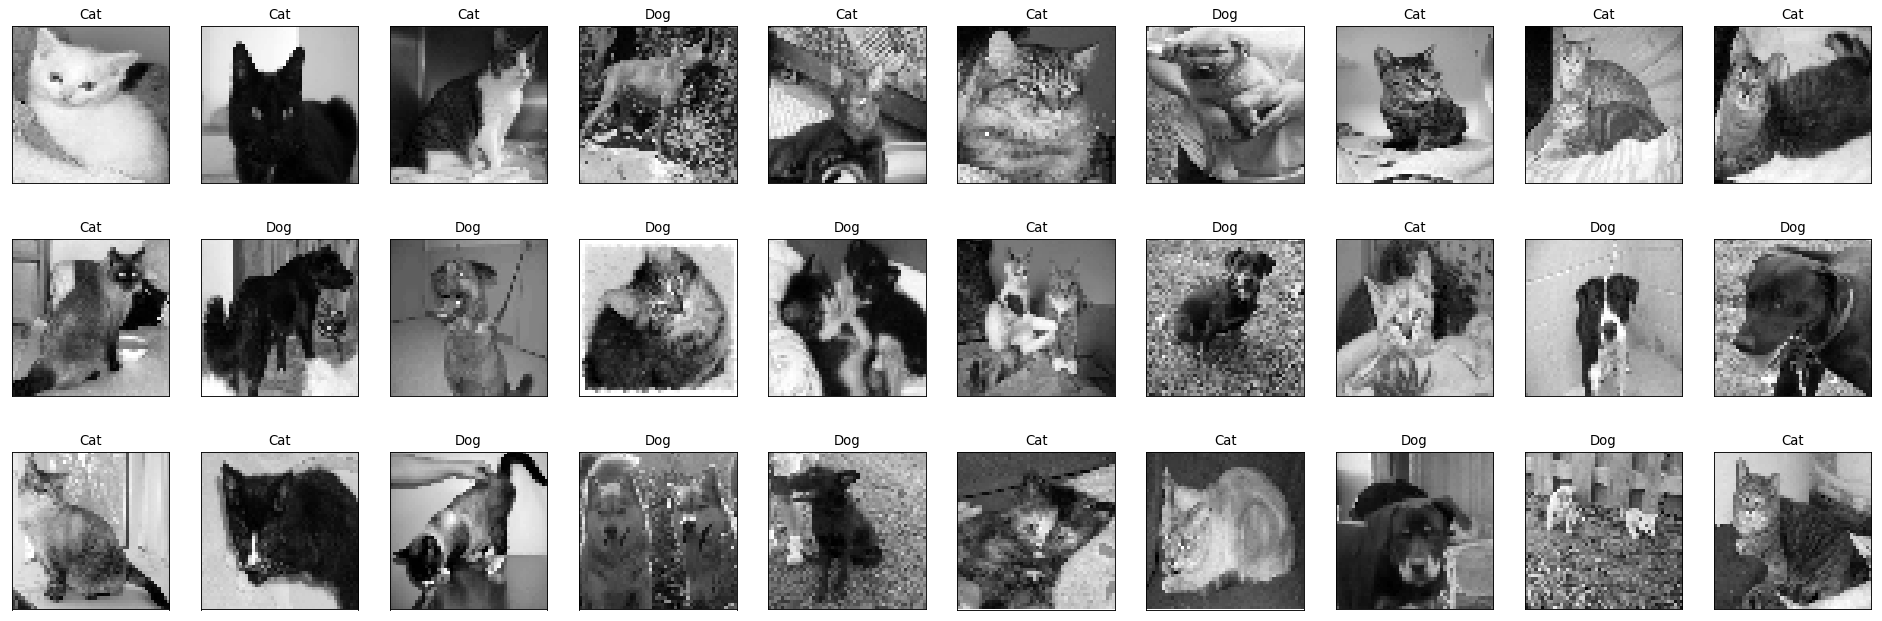

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline
test_data = np.load('test_data.npy')
fig=plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='w')
for num,data in enumerate(test_data[220:250]):
    # cat: [1,0]
    # dog: [0,1] 
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,10,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:38<00:00, 326.06it/s]
